# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
import nltk
nltk.download(['punkt', 'wordnet','averaged_perceptron_tagger'])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\wythe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\wythe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\wythe\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
# import libraries
import sys
import sqlite3
import os
from sqlalchemy import create_engine
import pandas as pd
import numpy as np


In [3]:
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score, make_scorer
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [4]:
# load data from database

engine = create_engine('sqlite:///C:/Users/wythe/Disaster_Response/data/DisasterResponse.db') 
df = pd.read_sql("select * from df", engine)
X = df.message.values
y = df[df.columns[4:]]
category_names = y.columns    


In [30]:
df.head()

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
category_names.T

Index(['related', 'request', 'offer', 'aid_related', 'medical_help',
       'medical_products', 'search_and_rescue', 'security', 'military',
       'child_alone', 'water', 'food', 'shelter', 'clothing', 'money',
       'missing_people', 'refugees', 'death', 'other_aid',
       'infrastructure_related', 'transport', 'buildings', 'electricity',
       'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure',
       'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold',
       'other_weather', 'direct_report'],
      dtype='object')

In [31]:
df.count()

id                        26215
message                   26215
original                  10170
genre                     26215
related                   26215
request                   26215
offer                     26215
aid_related               26215
medical_help              26215
medical_products          26215
search_and_rescue         26215
security                  26215
military                  26215
child_alone               26215
water                     26215
food                      26215
shelter                   26215
clothing                  26215
money                     26215
missing_people            26215
refugees                  26215
death                     26215
other_aid                 26215
infrastructure_related    26215
transport                 26215
buildings                 26215
electricity               26215
tools                     26215
hospitals                 26215
shops                     26215
aid_centers               26215
other_in

In [29]:
df[df.columns[4:]].sum()

related                   20093
request                    4474
offer                       118
aid_related               10860
medical_help               2084
medical_products           1313
search_and_rescue           724
security                    471
military                    860
child_alone                   0
water                      1672
food                       2923
shelter                    2314
clothing                    405
money                       604
missing_people              298
refugees                    875
death                      1194
other_aid                  3446
infrastructure_related     1705
transport                  1201
buildings                  1333
electricity                 532
tools                       159
hospitals                   283
shops                       120
aid_centers                 309
other_infrastructure       1151
weather_related            7297
floods                     2155
storm                      2443
fire    

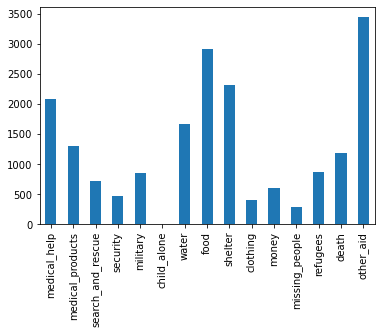

In [50]:
# plot 1
df.loc[:,'medical_help':'other_aid'].sum().plot(kind='bar');


In [34]:
# plot 2
df[['aid_related','infrastructure_related','weather_related']].sum()

aid_related               10860
infrastructure_related     1705
weather_related            7297
dtype: int64

<AxesSubplot:>

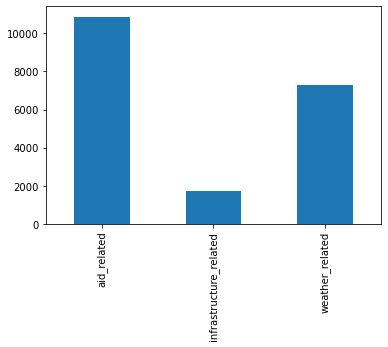

In [36]:
df[['aid_related','infrastructure_related','weather_related']].sum().plot(kind='bar')

In [ ]:
y.head()

### 2. Write a tokenization function to process your text data

In [ ]:
def tokenize(text):
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, "urlplaceholder")

    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()

    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)

    return clean_tokens

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [ ]:
pipeline = Pipeline([
    ('vect',CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf',MultiOutputClassifier(RandomForestClassifier(n_jobs=-1))),
])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [ ]:
pipeline.get_params().keys()

In [ ]:
# split data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.2)

In [ ]:
# train classifier
pipeline.fit(X_train, y_train)   
   

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [ ]:
# predict
y_pred = pipeline.predict(X_test)


In [ ]:
print(classification_report(y_test, y_pred, target_names = category_names))


### 6. Improve your model
Use grid search to find better parameters. 

In [ ]:
parameters = parameters = {
        'clf__estimator__n_estimators': [50, 100],
        'clf__estimator__min_samples_leaf': [5, 10]
}
    
cv = GridSearchCV(pipeline, param_grid=parameters, n_jobs=4, verbose=2)  

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [ ]:
cv.fit(X_train, y_train)

In [ ]:
y_pred_improved = cv.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred_improved, target_names=category_names))

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [ ]:
best_model = cv.best_params_

In [ ]:
best_model

In [ ]:
pipeline_1 = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(RandomForestClassifier(n_estimators=100,min_samples_leaf=10,
                                                             n_jobs=-1)))
    ])

In [ ]:
pipeline_1.fit(X_train, y_train)

In [ ]:
y_pred = pipeline_1.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred,target_names=category_names))

### 9. Export your model as a pickle file

In [ ]:
with open('model.pkl', 'wb') as model_file:
  pickle.dump(pipeline_1, model_file)

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.